# Profiling top-rated listings

## Libraries

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


import numpy as np
import os
import sys

## data

In [2]:
raw = pd.read_csv('cleaned_listings.csv')
df = raw[~raw['price'].isin([999, 9999])]
df = df.drop(['host_listings_count', 'host_total_listings_count', 'minimum_nights_avg_ntm','maximum_minimum_nights','minimum_nights','minimum_minimum_nights', 'property_type',
              'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','maximum_nights_avg_ntm','cnt_amenities'], axis=1)




## visualize the review_scores_rating

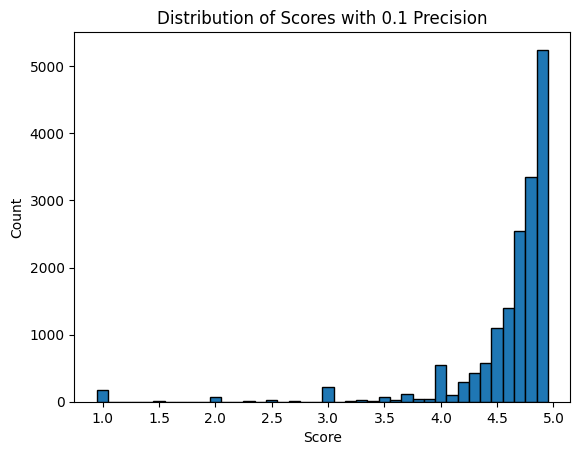

In [3]:
# Calculate counts of each value
value_counts = df['review_scores_rating'].value_counts()

# Sort the counts by index for better visualization
value_counts = value_counts.sort_index()

# Plotting
bin_edges = np.arange(0.95, 5.05, 0.1)
plt.hist(df['review_scores_rating'], bins=bin_edges, edgecolor='black')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores with 0.1 Precision')
plt.show()


In [4]:
index_to_drop = df['review_scores_rating'] <= 4.5
df = df[~index_to_drop]
df = df.drop(columns=['id','source','name','host_id','host_name'])


## Clustering on scores > 4.5

### Kmeans

In [5]:
df = df.drop(columns=['maximum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
       'has_availability'])

In [6]:
df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,price,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,has_description,has_host_about,cnt_verifications,months_since
0,within a few hours,1.0,0.75,0,1,1,Playa del Rey,Entire home/apt,2,120.0,...,5.00,5.00,5.00,0,1,0.04,1,0,18,109
1,within an hour,0.9,0.90,0,1,0,Castaic,Entire home/apt,14,1400.0,...,4.75,4.75,4.50,0,1,1.52,1,0,18,45
2,within an hour,1.0,1.00,1,1,1,Santa Clarita,Entire home/apt,2,201.0,...,5.00,4.97,4.86,0,2,2.88,1,1,18,107
3,within an hour,1.0,1.00,1,1,1,Inglewood,Entire home/apt,3,105.0,...,5.00,4.67,4.92,0,2,0.78,1,1,18,19
4,within an hour,1.0,0.97,0,1,1,Hawthorne,Private room,1,68.0,...,5.00,4.63,4.75,1,3,1.13,1,1,9,9


In [7]:
df.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month',
       'has_description', 'has_host_about', 'cnt_verifications',
       'months_since'],
      dtype='object')

In [8]:
# Define the order manually
order_mapping = {
    'a few days or more': 0,
    'within a day': 1,
    'within a few hours': 2,
    'within an hour': 3
}

# Apply the mapping to the column
df['host_response_time'] = df['host_response_time'].map(order_mapping)


In [19]:
df = df.drop(columns=['neighbourhood_cleansed'])

In [25]:
# Define numerical and categorical columns
numerical_cols = ['host_response_rate', 'host_acceptance_rate',
     'accommodates', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
    'cnt_verifications',
       'months_since']
categorical_cols = ['room_type']

# Create transformers for normalization and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(df)


### n_clusters in range(2,10)

In [31]:
n_score = {}
for n_clusters in range(2,10):
# Assuming X_processed is your pre-processed data
    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(X_processed)

# Reduce the data dimensions with TruncatedSVD
    svd = TruncatedSVD(n_components=2)
    reduced_data = svd.fit_transform(X_processed)

    score = silhouette_score(reduced_data, clusters)
    n_score[n_clusters] = score
    # Use the reduced data for silhouette score
print(n_score)

/Users/mac/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/o

{2: 0.2731824382812653, 3: 0.2732799476051785, 4: 0.27347962488957983, 5: 0.27320483644664567, 6: 0.27330184450465855, 7: 0.2738479415373326, 8: 0.2732049692558348, 9: 0.2732817935270247}


### visualize

In [ ]:
# Plotting the results
'''plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)

plt.xlabel('SVD Feature 1')
plt.ylabel('SVD Feature 2')
plt.title('K-Means Clustering (SVD-reduced Data)')
plt.colorbar(label='Cluster Label')
plt.show()'''

## Hierarchical Clustering:

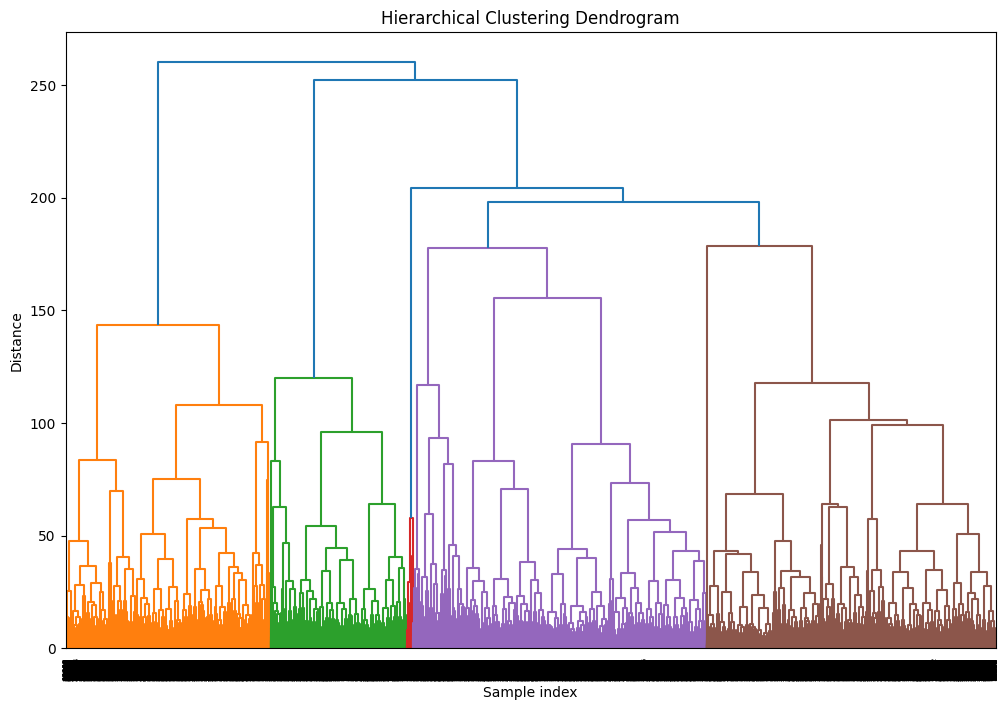

In [34]:
# Compute the linkage matrix
Z = linkage(X_processed, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Form clusters
max_d = 25  # Maximum distance for separating clusters, adjust this value based on the dendrogram
clusters = fcluster(Z, max_d, criterion='distance')

# Adding cluster labels to the original data
df['Cluster'] = clusters

In [37]:
distance_threshold = 200
clusters = fcluster(Z, distance_threshold, criterion='distance')

# Now you can check how many unique clusters you have
num_clusters = len(set(clusters))
print('Number of clusters formed:', num_clusters)
silhouette_avg = silhouette_score(X_processed, clusters)
print('The average silhouette_score is :', silhouette_avg)

Number of clusters formed: 4
The average silhouette_score is : 0.10619374020539098
